In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

# Preprocessing

In [2]:
d="/kaggle/input/garbage-classification/Garbage classification/Garbage classification"

In [3]:
classes=["cardboard","glass","metal","paper","plastic","trash"]

In [4]:
data=[]
for c in classes:
    i=classes.index(c)
    path=os.path.join(d,c)
    for img in os.listdir(path):
        im=cv2.imread(os.path.join(path,img))
        im=cv2.resize(im,(224,224))
        data.append([im,i])

In [5]:
data=np.array(data)
import random
random.shuffle(data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [6]:
X=[]
Y=[]
for x,y in data:
    X.append(x)
    Y.append(y)

In [7]:
x=np.array(X)
y=np.array(Y)
print(x.shape,y.shape)

(2527, 224, 224, 3) (2527,)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=4, stratify=y)

In [9]:
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(1895, 224, 224, 3) (1895,)
(632, 224, 224, 3) (632,)


# Build DenseNet169 Model

In [10]:
model_denseNet169=tf.keras.applications.densenet.DenseNet169(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

58541896/58541896 [==============================] - 1s 0us/step


In [12]:
model_denseNet169.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [11]:
base_input3=model_denseNet169.layers[0].input
base_output3=model_denseNet169.layers[-2].output

final_output3 = layers.Dense(240)(base_output3) 
final_output3 = layers.Activation('relu')(final_output3) 
final_output3 = layers.Dense(128)(final_output3) 
final_output3 = layers.Activation('relu')(final_output3) 
final_output3 = layers.Dense(64)(final_output3)
final_output3 = layers.Activation('relu')(final_output3)
final_output3 = layers.Dense(6, activation='softmax')(final_output3) 

In [12]:
new_model_denseNet169 = tf.keras.Model(inputs = base_input3, outputs = final_output3)

In [13]:
new_model_denseNet169.compile(loss="sparse_categorical_crossentropy", optimizer = "SGD", metrics = ["accuracy"])

# Train DenseNet169 Model

In [14]:
checkpoint_filepath = '/kaggle/working/new_model_denseNet169.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [15]:
result_D = new_model_denseNet169.fit(
    x_train, y_train, 
    epochs = 20,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/20
60/60 [==============================] - 98s 667ms/step - loss: 0.7355 - accuracy: 0.7731 - val_loss: 0.5592 - val_accuracy: 0.7927
Epoch 2/20
60/60 [==============================] - 30s 502ms/step - loss: 0.2106 - accuracy: 0.9425 - val_loss: 0.5073 - val_accuracy: 0.8149
Epoch 3/20
60/60 [==============================] - 31s 514ms/step - loss: 0.0870 - accuracy: 0.9815 - val_loss: 0.2746 - val_accuracy: 0.9130
Epoch 4/20
60/60 [==============================] - 32s 526ms/step - loss: 0.0469 - accuracy: 0.9937 - val_loss: 0.1385 - val_accuracy: 0.9573
Epoch 5/20
60/60 [==============================] - 31s 518ms/step - loss: 0.0295 - accuracy: 0.9953 - val_loss: 0.1224 - val_accuracy: 0.9620
Epoch 6/20
60/60 [==============================] - 29s 484ms/step - loss: 0.0195 - accuracy: 0.9963 - val_loss: 0.1386 - val_accuracy: 0.9620
Epoch 7/20
60/60 [==============================] - 29s 491ms/step - loss: 0.0158 - accuracy: 0.9974 - val_loss: 0.1416 - val_accuracy: 0.9494

In [17]:
new_model = tf.keras.models.load_model(checkpoint_filepath)

In [51]:
import cv2
from random import randint

In [52]:
test_imgs = list()
prev_idx = None
for i in range(5):
    cur_idx = randint(0, 630)
    while cur_idx == prev_idx:
        cur_idx = randint(0, 630)
        
    img = np.reshape(x_test[cur_idx], [1, 224, 224, 3])
    img_class = y_test[cur_idx]
    
    test_imgs.append((img, img_class))
    
    prev_idx = cur_idx

In [73]:
for i in range(5):
    res = new_model.predict(test_imgs[i][0])
    max_val = np.max(res)
    res = res.tolist()
    print(
        f"predicted class: {classes[res[0].index(max_val)]}, actual class: {classes[test_imgs[i][1]]}"
    )

1/1 [==============================] - 0s 44ms/step
predicted class: cardboard, actual class: cardboard
1/1 [==============================] - 0s 41ms/step
predicted class: cardboard, actual class: cardboard
1/1 [==============================] - 0s 62ms/step
predicted class: cardboard, actual class: cardboard
1/1 [==============================] - 0s 77ms/step
predicted class: cardboard, actual class: cardboard
1/1 [==============================] - 0s 73ms/step
predicted class: glass, actual class: glass


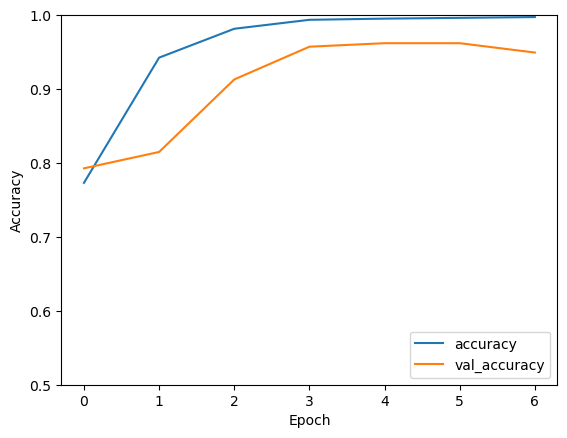

In [42]:
plt.plot(result_D.history['accuracy'], label='accuracy')
plt.plot(result_D.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')